In [2]:
import os
import wave
from glob import glob
import pandas as pd
import os
import librosa
import numpy as np
import webrtcvad
import soundfile as sf
from sklearn.mixture import GaussianMixture
import joblib
import re

In [3]:
def duree_totale_wav_dossier(dossier):
    duree_totale = 0.0
    
    # Lister tous les fichiers .wav et .wave dans le dossier
    fichiers_wav = glob(os.path.join(dossier, "*.wav")) + glob(os.path.join(dossier, "*.wave"))
    for fichier in fichiers_wav:
        try:
            with wave.open(fichier, 'rb') as f:
                frames = f.getnframes()
                rate = f.getframerate()
                duree_totale += frames / float(rate)
        except Exception as e:
            print(f"Erreur avec {fichier} : {e}")
    return duree_totale


In [4]:
total_spanish_train = duree_totale_wav_dossier("original_dataset/Spanish/train")
total_spanish_test = duree_totale_wav_dossier("original_dataset/Spanish/test")
total_french_test = duree_totale_wav_dossier("original_dataset/French/test")
total_french_train = duree_totale_wav_dossier("original_dataset/French/train")

data = {
    "Langue": [ "Espagnol","Français"],
    "Durée Train (min)": [total_spanish_train, total_french_train],
    "Durée Test (min)": [total_spanish_test, total_french_test],
}

df = pd.DataFrame(data)

# Conversion en minutes
df["Durée Train (min)"] = df["Durée Train (min)"] / 60
df["Durée Test (min)"] = df["Durée Test (min)"] / 60
df["Durée Totale (min)"] = df["Durée Train (min)"] + df["Durée Test (min)"]

# Affichage du tableau
print(df.to_markdown(index=False)) 


| Langue   |   Durée Train (min) |   Durée Test (min) |   Durée Totale (min) |
|:---------|--------------------:|-------------------:|---------------------:|
| Espagnol |             135.489 |            19.6229 |              155.112 |
| Français |             134.347 |            20.584  |              154.931 |


# Pretraitement

In [9]:
def remove_silence(audio, sr=16000, aggressiveness=3, frame_duration=30):
    vad = webrtcvad.Vad(aggressiveness)
    frame_len = int(sr * frame_duration / 1000)
    offset = 0
    voiced = []

    while offset + frame_len < len(audio):
        frame = audio[offset:offset + frame_len]
        pcm = (frame * 32768).astype(np.int16).tobytes()
        if vad.is_speech(pcm, sample_rate=sr):
            voiced.extend(frame)
        offset += frame_len

    return np.array(voiced)

def process_audio_folder(input_dir, output_dir, sr=16000):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(".wav"):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)

            try:
                audio, _ = librosa.load(input_path, sr=sr)
                cleaned_audio = remove_silence(audio, sr)
                if len(cleaned_audio) > 0:
                    sf.write(output_path, cleaned_audio, sr)
                    print(f"[✓] Processed: {filename}")
                else:
                    print(f"[!] Skipped (silent): {filename}")
            except Exception as e:
                print(f"[✗] Failed: {filename} — {e}")


## !process each language

In [12]:
languages = [ "Spanish", "French", "English", "Arabic"]

# Chemins des dossiers d'entrée et de sortie
input_root = "original_dataset"
output_root = "pretreated_dataset"

# Parcours de chaque langue et de chaque sous-dossier
for lang in languages:
    for subset in ["train", "test"]:
        input_folder = os.path.join(input_root, lang, subset)
        output_folder = os.path.join(output_root, lang, subset)

        # Vérifie si le dossier d'entrée existe
        if os.path.exists(input_folder):
            print(f"Traitement de {input_folder} → {output_folder}")
            process_audio_folder(input_folder, output_folder)
        else:
            print(f"⚠️ Dossier introuvable : {input_folder}")

Traitement de original_dataset\Spanish\train → pretreated_dataset\Spanish\train
[✓] Processed: F1.wav
[✓] Processed: F10.wav
[✓] Processed: F11.wav
[✓] Processed: F12.wav
[✓] Processed: F13.wav
[✓] Processed: F14.wav
[✓] Processed: F15.wav
[✓] Processed: F16.wav
[✓] Processed: F17.wav
[✓] Processed: F18.wav
[✓] Processed: F19.wav
[✓] Processed: F2.wav
[✓] Processed: F20.wav
[✓] Processed: F3.wav
[✓] Processed: F4.wav
[✓] Processed: F5.wav
[✓] Processed: F6.wav
[✓] Processed: F7.wav
[✓] Processed: F8.wav
[✓] Processed: F9.wav
[✓] Processed: H1.wav
[✓] Processed: H10.wav
[✓] Processed: H11.wav
[✓] Processed: H12.wav
[✓] Processed: H13.wav
[✓] Processed: H14.wav
[✓] Processed: H15.wav
[✓] Processed: H16.wav
[✓] Processed: H17.wav
[✓] Processed: H18.wav
[✓] Processed: H19.wav
[✓] Processed: H2.wav
[✓] Processed: H20.wav
[✓] Processed: H3.wav
[✓] Processed: H4.wav
[✓] Processed: H5.wav
[✓] Processed: H6.wav
[✓] Processed: H7.wav
[✓] Processed: H8.wav
[✓] Processed: H9.wav
Traitement de orig

# Extract mfccs

In [14]:
def extract_mfcc_from_folder(input_dir, output_dir, sr=16000, n_mfcc=13):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.lower().endswith(".wav"):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename.replace(".wav", ".npy"))

            try:
                # 1. Load audio
                y, _ = librosa.load(input_path, sr=sr)

                # 2. Extract MFCCs
                mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)

                # 3. (Optional) Add delta and delta-delta
                delta = librosa.feature.delta(mfcc)
                delta2 = librosa.feature.delta(mfcc, order=2)
                mfcc_all = np.vstack([mfcc, delta, delta2])  # shape: (n_mfcc*3, T)

                # 4. Save as .npy
                np.save(output_path, mfcc_all.T)  # shape: (T, n_features)
                print(f"[✓] Saved MFCCs: {filename} → {output_path}")

            except Exception as e:
                print(f"[✗] Failed on {filename}: {e}")

## !process each language

In [17]:
input_root ="pretreated_dataset"
output_root = "mfcc_new"

# Parcours de chaque langue et de chaque sous-dossier
for lang in languages:
    for subset in ["train", "test"]:
        input_folder = os.path.join(input_root, lang, subset)
        output_folder = os.path.join(output_root, lang, subset)

        # Vérifie si le dossier d'entrée existe
        if os.path.exists(input_folder):
            print(f"Extraction des MFCCs de {input_folder} → {output_folder}")
            extract_mfcc_from_folder(input_folder, output_folder)
        else:
            print(f"⚠️ Dossier introuvable : {input_folder}")

Extraction des MFCCs de pretreated_dataset\Spanish\train → mfcc_new\Spanish\train
[✓] Saved MFCCs: F1.wav → mfcc_new\Spanish\train\F1.npy
[✓] Saved MFCCs: F10.wav → mfcc_new\Spanish\train\F10.npy
[✓] Saved MFCCs: F11.wav → mfcc_new\Spanish\train\F11.npy
[✓] Saved MFCCs: F12.wav → mfcc_new\Spanish\train\F12.npy
[✓] Saved MFCCs: F13.wav → mfcc_new\Spanish\train\F13.npy
[✓] Saved MFCCs: F14.wav → mfcc_new\Spanish\train\F14.npy
[✓] Saved MFCCs: F15.wav → mfcc_new\Spanish\train\F15.npy
[✓] Saved MFCCs: F16.wav → mfcc_new\Spanish\train\F16.npy
[✓] Saved MFCCs: F17.wav → mfcc_new\Spanish\train\F17.npy
[✓] Saved MFCCs: F18.wav → mfcc_new\Spanish\train\F18.npy
[✓] Saved MFCCs: F19.wav → mfcc_new\Spanish\train\F19.npy
[✓] Saved MFCCs: F2.wav → mfcc_new\Spanish\train\F2.npy
[✓] Saved MFCCs: F20.wav → mfcc_new\Spanish\train\F20.npy
[✓] Saved MFCCs: F3.wav → mfcc_new\Spanish\train\F3.npy
[✓] Saved MFCCs: F4.wav → mfcc_new\Spanish\train\F4.npy
[✓] Saved MFCCs: F5.wav → mfcc_new\Spanish\train\F5.npy


# Training

In [19]:
import os
import numpy as np

def load_mfccs(folder_path):
    mfcc_list = []
    if not os.path.exists(folder_path):
        print(f"[AVERTISSEMENT] Dossier inexistant : {folder_path}")
        return np.empty((0, 13))  # ou une autre dimension par défaut
    
    files = [f for f in os.listdir(folder_path) if f.endswith('.npy')]
    if not files:
        print(f"[INFO] Aucun fichier MFCC trouvé dans : {folder_path}")
        return np.empty((0, 13))  # dimension typique des MFCC

    for fname in files:
        path = os.path.join(folder_path, fname)
        try:
            mfcc = np.load(path)
            mfcc_list.append(mfcc)
        except Exception as e:
            print(f"Erreur en chargeant {path} : {e}")

    if not mfcc_list:
        print(f"[INFO] Liste MFCC vide dans : {folder_path}")
        return np.empty((0, 13))
    
    return np.vstack(mfcc_list)

def train_gmms(data_root, output_dir, n_components_list=[8, 16, 32, 64, 128, 256]):
    os.makedirs(output_dir, exist_ok=True)
    languages = [d for d in os.listdir(data_root) if os.path.isdir(os.path.join(data_root, d))]

    for n_components in n_components_list:
        print(f"\n🔧 Training GMMs with {n_components} Gaussians")

        for lang in languages:
            lang_path = os.path.join(data_root, lang)
            features = load_mfccs(lang_path)

            print(f"  → Training for language: {lang} ({features.shape[0]} frames)")

            gmm = GaussianMixture(n_components=n_components, covariance_type='diag', max_iter=100, random_state=42)
            gmm.fit(features)

            model_path = os.path.join(output_dir, f"{lang}_gmm_{n_components}.joblib")
            joblib.dump(gmm, model_path)
            print(f"    [✓] Saved model: {model_path}")

In [23]:
data_root = "mfcc_new"       # dossier contenant les sous-dossiers langues avec sous-dossiers train/test
model_save_path = "gmm_models_new"
train_gmms(data_root, model_save_path, n_components_list=[8, 16, 32, 64, 128, 256,512,1024])


🔧 Training GMMs with 8 Gaussians
  → Training for language: Arabic (203981 frames)
    [✓] Saved model: gmm_models_new\Arabic_gmm_8.joblib
  → Training for language: English (191484 frames)
    [✓] Saved model: gmm_models_new\English_gmm_8.joblib
  → Training for language: French (202383 frames)
    [✓] Saved model: gmm_models_new\French_gmm_8.joblib
  → Training for language: Spanish (207646 frames)
    [✓] Saved model: gmm_models_new\Spanish_gmm_8.joblib

🔧 Training GMMs with 16 Gaussians
  → Training for language: Arabic (203981 frames)
    [✓] Saved model: gmm_models_new\Arabic_gmm_16.joblib
  → Training for language: English (191484 frames)
    [✓] Saved model: gmm_models_new\English_gmm_16.joblib
  → Training for language: French (202383 frames)
    [✓] Saved model: gmm_models_new\French_gmm_16.joblib
  → Training for language: Spanish (207646 frames)
    [✓] Saved model: gmm_models_new\Spanish_gmm_16.joblib

🔧 Training GMMs with 32 Gaussians
  → Training for language: Arabic (2

In [27]:
import os
import numpy as np
import librosa
import joblib
import webrtcvad
import soundfile as sf
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# === Same silence removal as in training ===
def remove_silence(audio, sr=16000, aggressiveness=3, frame_duration=30):
    vad = webrtcvad.Vad(aggressiveness)
    frame_len = int(sr * frame_duration / 1000)
    offset = 0
    voiced = []

    while offset + frame_len < len(audio):
        frame = audio[offset:offset + frame_len]
        pcm = (frame * 32768).astype(np.int16).tobytes()
        if vad.is_speech(pcm, sample_rate=sr):
            voiced.extend(frame)
        offset += frame_len

    return np.array(voiced)


# === Feature extraction using VAD ===
def extract_features(file_path, sr=16000, n_mfcc=13):
    y, _ = librosa.load(file_path, sr=sr)

    # Apply same silence removal as training
    y_clean = remove_silence(y, sr=sr)

    # Edge case: file is empty after VAD
    if len(y_clean) == 0:
        return np.zeros((1, n_mfcc * 3))

    mfcc = librosa.feature.mfcc(y=y_clean, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    mfcc_all = np.vstack([mfcc, delta, delta2])  # (39, T)

    return mfcc_all.T  # shape: (T, 39)


# === Evaluation loop ===
def evaluate_gmm_models(test_path, model_path, n_components_list=[8, 16, 32, 64, 128, 256,512,1024]):
    class_names = [d for d in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, d))]
    class_names = [name.lower() for name in class_names]
    label_map = {name: idx for idx, name in enumerate(sorted(class_names))}
    inv_label_map = {v: k for k, v in label_map.items()}  # reverse map for easy lookup

    file_paths = []
    true_labels = []
    for lang in class_names:
        full_path = os.path.join(test_path, lang)
        for file in os.listdir(full_path):
            if file.endswith(".wav"):
                file_paths.append(os.path.join(full_path, file))
                true_labels.append(label_map[lang])

    true_labels = np.array(true_labels)

    for n_comp in n_components_list:
        print(f"\nEvaluating GMM models with {n_comp} components...")
        gmm_models = {}
        for lang in class_names:
            model_filename = f"{lang.capitalize()}_gmm_{n_comp}.joblib"
            model_file = os.path.join(model_path, model_filename)
            if os.path.exists(model_file):
                gmm_models[lang] = joblib.load(model_file)
            else:
                print(f"⚠️ Model not found: {model_file}")

        predictions = []
        misclassified_files = []

        for idx, path in enumerate(tqdm(file_paths, desc=f"Testing {n_comp} components")):
            features = extract_features(path)
            scores = {lang: model.score(features) for lang, model in gmm_models.items()}
            predicted_lang = max(scores, key=scores.get)
            predictions.append(label_map[predicted_lang])

            # Check misclassification
            if label_map[predicted_lang] != true_labels[idx]:
                true_lang_name = inv_label_map[true_labels[idx]]
                pred_lang_name = predicted_lang
                misclassified_files.append(
                    (os.path.basename(path), true_lang_name, pred_lang_name)
                )

        acc = accuracy_score(true_labels, predictions)
        cm = confusion_matrix(true_labels, predictions)
        print(f"✅ Accuracy with {n_comp} Gaussians: {acc*100:.2f}%")
        print("Confusion Matrix:")
        print(cm)

        if misclassified_files:
            print(f"\n❌ Misclassified audio files for {n_comp} components:")
            for fname, true_label, pred_label in misclassified_files:
                print(f"  File: {fname}, True: {true_label}, Predicted: {pred_label}")
        else:
            print("No misclassifications!")

        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=sorted(label_map.keys()),
                    yticklabels=sorted(label_map.keys()))
        plt.title(f"Confusion Matrix for GMM with {n_comp} Components")
        plt.xlabel("Predicted Language")
        plt.ylabel("True Language")
        plt.show()



Evaluating GMM models with 8 components...


Testing 8 components: 100%|██████████████████████████████████████████████████████████| 130/130 [00:32<00:00,  4.01it/s]


✅ Accuracy with 8 Gaussians: 63.85%
Confusion Matrix:
[[16  1  1  2]
 [ 8 15  2  5]
 [ 5  3 24  8]
 [ 8  2  2 28]]

❌ Misclassified audio files for 8 components:
  File: F2.wav, True: arabic, Predicted: french
  File: H6.wav, True: arabic, Predicted: spanish
  File: H7.wav, True: arabic, Predicted: english
  File: H9.wav, True: arabic, Predicted: spanish
  File: F12.wav, True: english, Predicted: arabic
  File: F13.wav, True: english, Predicted: arabic
  File: F14.wav, True: english, Predicted: arabic
  File: F15.wav, True: english, Predicted: arabic
  File: F2.wav, True: english, Predicted: arabic
  File: F3.wav, True: english, Predicted: spanish
  File: F4.wav, True: english, Predicted: spanish
  File: F5.wav, True: english, Predicted: arabic
  File: F6.wav, True: english, Predicted: arabic
  File: F9.wav, True: english, Predicted: french
  File: H1.wav, True: english, Predicted: spanish
  File: H14.wav, True: english, Predicted: french
  File: H3.wav, True: english, Predicted: spani

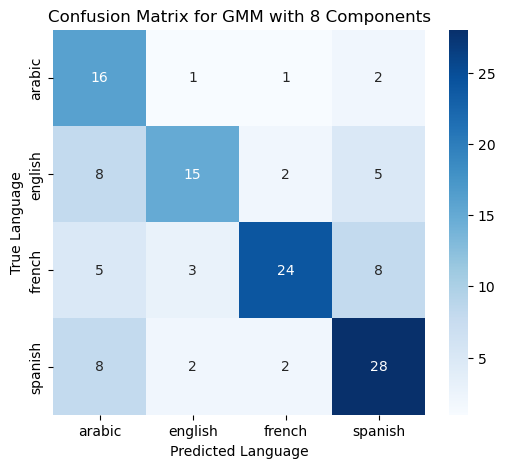


Evaluating GMM models with 16 components...


Testing 16 components: 100%|█████████████████████████████████████████████████████████| 130/130 [00:33<00:00,  3.83it/s]


✅ Accuracy with 16 Gaussians: 70.00%
Confusion Matrix:
[[17  1  0  2]
 [ 5 19  2  4]
 [ 5  1 27  7]
 [ 8  1  3 28]]

❌ Misclassified audio files for 16 components:
  File: H6.wav, True: arabic, Predicted: spanish
  File: H7.wav, True: arabic, Predicted: english
  File: H9.wav, True: arabic, Predicted: spanish
  File: F12.wav, True: english, Predicted: arabic
  File: F2.wav, True: english, Predicted: arabic
  File: F3.wav, True: english, Predicted: spanish
  File: F5.wav, True: english, Predicted: arabic
  File: F6.wav, True: english, Predicted: arabic
  File: F9.wav, True: english, Predicted: french
  File: H1.wav, True: english, Predicted: spanish
  File: H14.wav, True: english, Predicted: french
  File: H3.wav, True: english, Predicted: spanish
  File: H7.wav, True: english, Predicted: arabic
  File: H8.wav, True: english, Predicted: spanish
  File: F11.wav, True: french, Predicted: english
  File: F12.wav, True: french, Predicted: arabic
  File: F13.wav, True: french, Predicted: ara

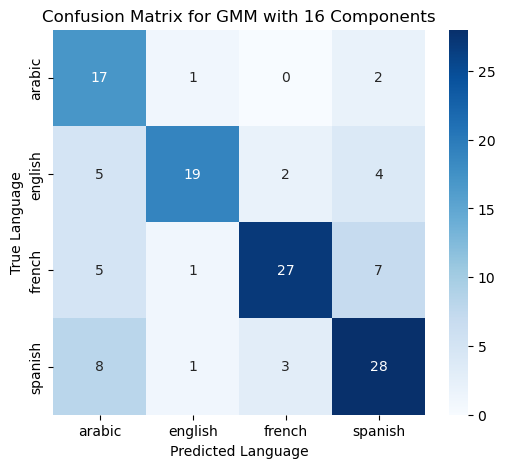


Evaluating GMM models with 32 components...


Testing 32 components: 100%|█████████████████████████████████████████████████████████| 130/130 [00:32<00:00,  3.98it/s]


✅ Accuracy with 32 Gaussians: 74.62%
Confusion Matrix:
[[19  0  1  0]
 [ 4 20  2  4]
 [ 3  4 27  6]
 [ 6  1  2 31]]

❌ Misclassified audio files for 32 components:
  File: H6.wav, True: arabic, Predicted: french
  File: F12.wav, True: english, Predicted: arabic
  File: F3.wav, True: english, Predicted: spanish
  File: F5.wav, True: english, Predicted: arabic
  File: F6.wav, True: english, Predicted: arabic
  File: F9.wav, True: english, Predicted: french
  File: H1.wav, True: english, Predicted: spanish
  File: H14.wav, True: english, Predicted: french
  File: H3.wav, True: english, Predicted: spanish
  File: H7.wav, True: english, Predicted: arabic
  File: H8.wav, True: english, Predicted: spanish
  File: F11.wav, True: french, Predicted: arabic
  File: F12.wav, True: french, Predicted: spanish
  File: F13.wav, True: french, Predicted: arabic
  File: F14.wav, True: french, Predicted: arabic
  File: F17.wav, True: french, Predicted: spanish
  File: F19.wav, True: french, Predicted: eng

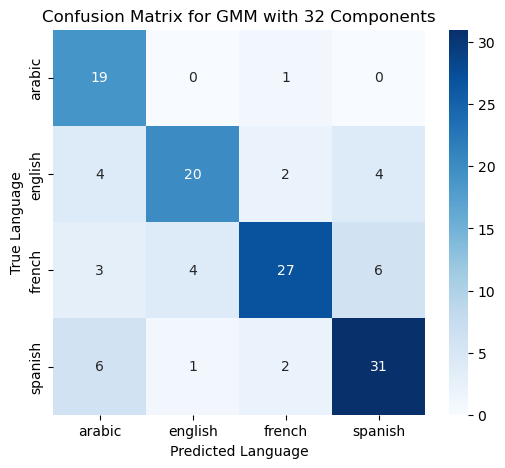


Evaluating GMM models with 64 components...


Testing 64 components: 100%|█████████████████████████████████████████████████████████| 130/130 [00:34<00:00,  3.81it/s]


✅ Accuracy with 64 Gaussians: 75.38%
Confusion Matrix:
[[19  0  1  0]
 [ 4 21  2  3]
 [ 4  2 29  5]
 [ 8  1  2 29]]

❌ Misclassified audio files for 64 components:
  File: H6.wav, True: arabic, Predicted: french
  File: F12.wav, True: english, Predicted: arabic
  File: F3.wav, True: english, Predicted: spanish
  File: F5.wav, True: english, Predicted: arabic
  File: F6.wav, True: english, Predicted: arabic
  File: F9.wav, True: english, Predicted: french
  File: H1.wav, True: english, Predicted: spanish
  File: H14.wav, True: english, Predicted: french
  File: H3.wav, True: english, Predicted: spanish
  File: H7.wav, True: english, Predicted: arabic
  File: F11.wav, True: french, Predicted: arabic
  File: F12.wav, True: french, Predicted: spanish
  File: F13.wav, True: french, Predicted: arabic
  File: F14.wav, True: french, Predicted: arabic
  File: F17.wav, True: french, Predicted: spanish
  File: F5.wav, True: french, Predicted: arabic
  File: F6.wav, True: french, Predicted: englis

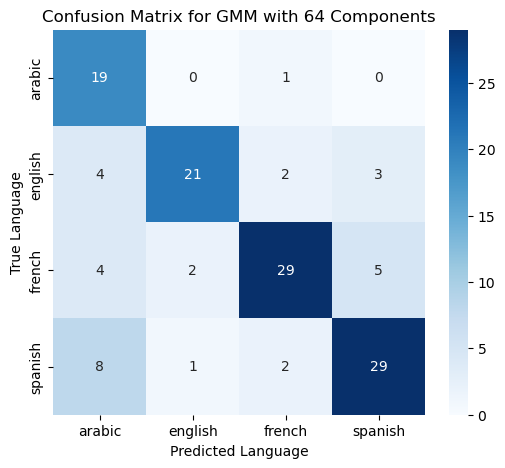


Evaluating GMM models with 128 components...


Testing 128 components: 100%|████████████████████████████████████████████████████████| 130/130 [00:38<00:00,  3.37it/s]


✅ Accuracy with 128 Gaussians: 79.23%
Confusion Matrix:
[[20  0  0  0]
 [ 4 22  1  3]
 [ 4  2 29  5]
 [ 6  1  1 32]]

❌ Misclassified audio files for 128 components:
  File: F12.wav, True: english, Predicted: arabic
  File: F3.wav, True: english, Predicted: spanish
  File: F5.wav, True: english, Predicted: arabic
  File: F6.wav, True: english, Predicted: arabic
  File: H1.wav, True: english, Predicted: spanish
  File: H14.wav, True: english, Predicted: french
  File: H3.wav, True: english, Predicted: spanish
  File: H7.wav, True: english, Predicted: arabic
  File: F11.wav, True: french, Predicted: arabic
  File: F12.wav, True: french, Predicted: spanish
  File: F13.wav, True: french, Predicted: arabic
  File: F14.wav, True: french, Predicted: arabic
  File: F17.wav, True: french, Predicted: spanish
  File: F5.wav, True: french, Predicted: arabic
  File: F6.wav, True: french, Predicted: english
  File: H14.wav, True: french, Predicted: english
  File: H2.wav, True: french, Predicted: sp

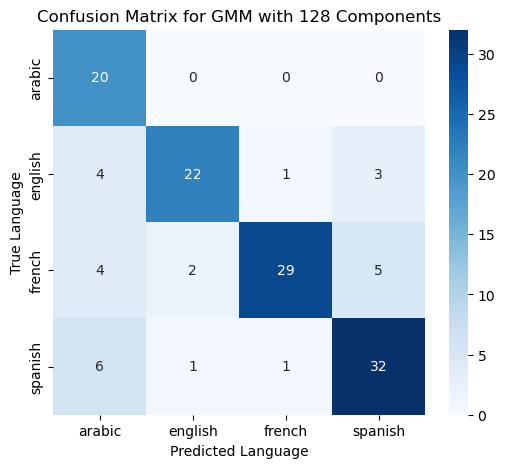


Evaluating GMM models with 256 components...


Testing 256 components: 100%|████████████████████████████████████████████████████████| 130/130 [00:38<00:00,  3.41it/s]


✅ Accuracy with 256 Gaussians: 79.23%
Confusion Matrix:
[[20  0  0  0]
 [ 3 21  2  4]
 [ 3  3 30  4]
 [ 6  1  1 32]]

❌ Misclassified audio files for 256 components:
  File: F12.wav, True: english, Predicted: arabic
  File: F3.wav, True: english, Predicted: spanish
  File: F6.wav, True: english, Predicted: arabic
  File: F9.wav, True: english, Predicted: french
  File: H1.wav, True: english, Predicted: spanish
  File: H14.wav, True: english, Predicted: french
  File: H3.wav, True: english, Predicted: spanish
  File: H7.wav, True: english, Predicted: arabic
  File: H8.wav, True: english, Predicted: spanish
  File: F11.wav, True: french, Predicted: arabic
  File: F12.wav, True: french, Predicted: spanish
  File: F13.wav, True: french, Predicted: arabic
  File: F14.wav, True: french, Predicted: arabic
  File: F17.wav, True: french, Predicted: spanish
  File: F19.wav, True: french, Predicted: english
  File: F6.wav, True: french, Predicted: english
  File: H14.wav, True: french, Predicted:

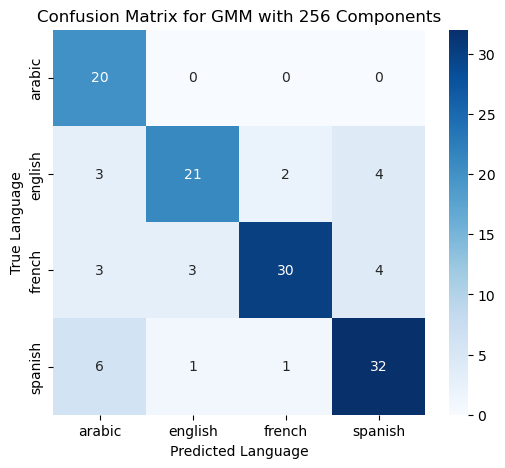


Evaluating GMM models with 512 components...


Testing 512 components: 100%|████████████████████████████████████████████████████████| 130/130 [00:50<00:00,  2.58it/s]

✅ Accuracy with 512 Gaussians: 79.23%
Confusion Matrix:
[[20  0  0  0]
 [ 3 21  2  4]
 [ 4  3 30  3]
 [ 7  1  0 32]]

❌ Misclassified audio files for 512 components:
  File: F12.wav, True: english, Predicted: arabic
  File: F3.wav, True: english, Predicted: spanish
  File: F6.wav, True: english, Predicted: arabic
  File: F9.wav, True: english, Predicted: french
  File: H1.wav, True: english, Predicted: spanish
  File: H14.wav, True: english, Predicted: french
  File: H3.wav, True: english, Predicted: spanish
  File: H7.wav, True: english, Predicted: arabic
  File: H8.wav, True: english, Predicted: spanish
  File: F11.wav, True: french, Predicted: arabic
  File: F12.wav, True: french, Predicted: arabic
  File: F13.wav, True: french, Predicted: arabic
  File: F14.wav, True: french, Predicted: arabic
  File: F17.wav, True: french, Predicted: spanish
  File: F19.wav, True: french, Predicted: english
  File: F6.wav, True: french, Predicted: english
  File: H14.wav, True: french, Predicted: 

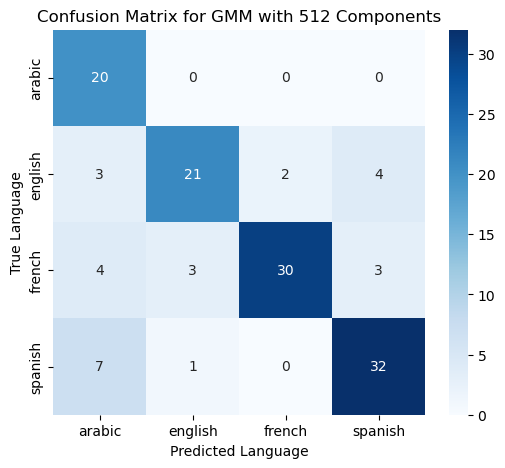


Evaluating GMM models with 1024 components...


Testing 1024 components: 100%|███████████████████████████████████████████████████████| 130/130 [01:04<00:00,  2.03it/s]


✅ Accuracy with 1024 Gaussians: 81.54%
Confusion Matrix:
[[20  0  0  0]
 [ 3 23  1  3]
 [ 4  3 30  3]
 [ 6  1  0 33]]

❌ Misclassified audio files for 1024 components:
  File: F12.wav, True: english, Predicted: arabic
  File: F3.wav, True: english, Predicted: spanish
  File: F6.wav, True: english, Predicted: arabic
  File: H1.wav, True: english, Predicted: spanish
  File: H14.wav, True: english, Predicted: french
  File: H3.wav, True: english, Predicted: spanish
  File: H7.wav, True: english, Predicted: arabic
  File: F11.wav, True: french, Predicted: arabic
  File: F12.wav, True: french, Predicted: arabic
  File: F13.wav, True: french, Predicted: arabic
  File: F14.wav, True: french, Predicted: arabic
  File: F17.wav, True: french, Predicted: spanish
  File: F19.wav, True: french, Predicted: english
  File: F6.wav, True: french, Predicted: english
  File: H14.wav, True: french, Predicted: english
  File: H2.wav, True: french, Predicted: spanish
  File: H4.wav, True: french, Predicted:

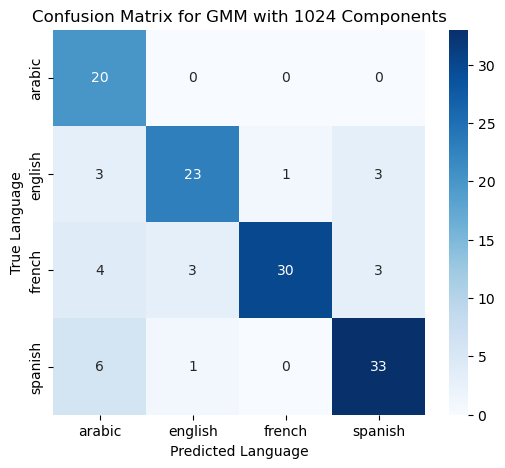

In [37]:
# Usage:
test_data_root = "testing_audios"  # Should contain "arabic/" and "english/" subfolders
model_dir = "gmm_models_new"
results = evaluate_gmm_models(test_data_root, model_dir)